In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'livelossplot'

# 2.公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

# 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


https://www.tensorflow.org/tutorials

## kerasによるMLの基本➡︎前処理されたテキストによるテキスト分類➡︎映画レビューのテキスト分類

ここでは、映画のレビューをそのテキストを使って肯定的か否定的かに分類します。これは、二値分類あるいは2クラス分類という問題の例であり、機械学習において重要でいろいろな応用が可能なものです。

ここでは、Internet Movie Databaseから抽出した50,000件の映画レビューを含む、 IMDB dataset を使います。レビューは訓練用とテスト用に25,000件ずつに分割されています。訓練用とテスト用のデータは均衡しています。言い換えると、それぞれが同数の肯定的及び否定的なレビューを含んでいます。

ここでは、TensorFlowを使ってモデルを構築・訓練するためのハイレベルなAPIである tf.kerasを使用します。tf.kerasを使ったもう少し高度なテキスト分類のチュートリアルについては、 MLCC Text Classification Guideを参照してください。

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.15.0


# IMDB datasetのダウンロード
IMDBデータセットは、TensorFlowにパッケージ化されています。それは前処理済みのものであり、（単語の連なりである）レビューが、整数の配列に変換されています。そこでは整数が辞書中の特定の単語を表します。

次のコードは、IMDBデータセットをあなたのパソコンにダウンロードします。（すでにダウンロードしていれば、キャッシュされたコピーを使用します）

In [4]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

num_words=10000という引数は、訓練データ中に出てくる単語のうち、最も頻繁に出現する10,000個を保持するためのものです。データサイズを管理可能にするため、稀にしか出現しない単語は破棄されます。

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


レビューのテキストは複数の整数に変換されており、それぞれの整数が辞書の中の特定の単語を表します。最初のレビューがどのようなものか見てみましょう。

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [8]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

# 整数を単語に戻してみる
整数をテキストに戻す方法を知っていると便利です。整数を文字列にマッピングする辞書オブジェクトを検索するためのヘルパー関数を定義します。

In [9]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_reviewを使うと、最初のレビューのテキストを表示できます。

In [10]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [11]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [12]:
train_labels[0]

1

# データの準備
レビュー（整数の配列）は、ニューラルネットワークに投入する前に、テンソルに変換する必要があります。これには2つ方法があります。

配列をワンホット（one-hot）エンコーディングと同じように、単語の出現を表す0と1のベクトルに変換します。

例えば、[3, 5]という配列は、インデックス3と5を除いてすべてゼロの10,000次元のベクトルになります。

そして、これをネットワークの最初の層、すなわち、浮動小数点のベクトルデータを扱うことができるDense（全結合）層とします。ただし、これは単語数×レビュー数の行列が必要なメモリ集約的な方法です。

もう一つの方法では、配列をパディングによって同じ長さに揃え、サンプル数 * 長さの最大値の形の整数テンソルにします。

そして、この形式を扱うことができるEmbedding（埋め込み）層をネットワークの最初の層にします。このチュートリアルでは、後者を採用することにします。

映画レビューは同じ長さでなければならないので、長さを標準化する pad_sequences 関数を使うことにします。

In [13]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,#パディング （文章の長さを合わせる
                                                        value=word_index["<PAD>"],#value: 浮動小数点数．パディングする値(今回は最初に０と指定している)
                                                        padding='post',#padding: 文字列，'pre'または'post'．各シーケンスの前後どちらを埋めるか．
                                                        maxlen=256)#最大の単語数

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

サンプルの長さを見てみましょう。

In [14]:
len(train_data[0]), len(train_data[1])

(256, 256)

次に、パディング済みの最初のサンプルを確認します。

In [15]:
print(train_data[0])
print(train_data[0].shape)

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [16]:
print(train_data[2])
print(train_data[2].shape)

[   1   14   47    8   30   31    7    4  249  108    7    4 5974   54
   61  369   13   71  149   14   22  112    4 2401  311   12   16 3711
   33   75   43 1829  296    4   86  320   35  534   19  263 4821 1301
    4 1873   33   89   78   12   66   16    4  360    7    4   58  316
  334   11    4 1716   43  645  662    8  257   85 1200   42 1228 2578
   83   68 3912   15   36  165 1539  278   36   69    2  780    8  106
   14 6905 1338   18    6   22   12  215   28  610   40    6   87  326
   23 2300   21   23   22   12  272   40   57   31   11    4   22   47
    6 2307   51    9  170   23  595  116  595 1352   13  191   79  638
   89    2   14    9    8  106  607  624   35  534    6  227    7  129
  113    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# モデルの構築
ニューラルネットワークは、層を積み重ねることで構成されます。この際、２つの大きな決定が必要です。

モデルにいくつの層を設けるか？
層ごとに何個の隠れユニットを使用するか？
この例では、入力データは単語インデックスの配列で構成されています。推定の対象となるラベルは、0または1です。この問題のためのモデルを構築しましょう。

In [17]:
# 入力の形式は映画レビューで使われている語彙数（10,000語）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))#文中の単語をベクトル表現にする
model.add(keras.layers.GlobalAveragePooling1D())#１次元のグローバル平均プーリング層。
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


これらの層は、分類器を構成するため一列に積み重ねられます。

最初の層はEmbedding（埋め込み）層です。この層は、整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索します。

埋め込みベクトルは、モデルの訓練の中で学習されます。ベクトル化のために、出力行列には次元が１つ追加されます。その結果、次元は、(batch, sequence, embedding)となります。
次は、GlobalAveragePooling1D（１次元のグローバル平均プーリング）層です。

この層は、それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返します。この結果、モデルは最も単純な形で、可変長の入力を扱うことができるようになります。
この固定長の出力ベクトルは、16個の隠れユニットを持つ全結合（Dense）層に受け渡されます。

最後の層は、1個の出力ノードに全結合されます。シグモイド（sigmoid）活性化関数を使うことで、値は確率あるいは確信度を表す0と1の間の浮動小数点数となります。

# 隠れユニット
上記のモデルには、入力と出力の間に、2つの中間層あるいは「隠れ」層があります。出力（ユニット、ノード、またはニューロン）は、その層の内部表現の次元数です。

言い換えると、このネットワークが学習によって内部表現を獲得する際の自由度ということです。

モデルにより多くの隠れユニットがある場合（内部表現空間の次元数がより大きい場合）、または、より多くの層がある場合、あるいはその両方の場合、ネットワークはより複雑な内部表現を学習することができます。

しかしながら、その結果として、ネットワークの計算量が多くなるほか、学習してほしくないパターンを学習するようになります。

学習してほしくないパターンとは、訓練データでの性能は向上するものの、テスト用データの性能が向上しないパターンです。この問題を過学習（overfitting）といいます。この問題は後ほど検証することになります。

# 損失関数とオプティマイザ
モデルを訓練するには、損失関数とオプティマイザが必要です。

今回の問題は二値分類問題であり、モデルの出力は確率（1ユニットの層とシグモイド活性化関数）であるため、損失関数としてbinary_crossentropy（2値のクロスエントロピー）関数を使用することにします。

損失関数の候補はこれだけではありません。例えば、mean_squared_error（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うにはbinary_crossentropyの方が適しています。

binary_crossentropyは、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

後ほど、回帰問題を検証する際には（例えば家屋の値段を推定するとか）、もう一つの損失関数であるmean_squared_error（平均二乗誤差）の使い方を目にすることになります。

さて、モデルのオプティマイザと損失関数を設定しましょう。

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# 検証用データを作る
訓練を行う際、モデルが見ていないデータでの正解率を検証したいと思います。

もとの訓練用データから、10,000個のサンプルを取り分けて検証用データ（validation set）を作ります。

（なぜ、ここでテスト用データを使わないのでしょう？ 今回の目的は、訓練用データだけを使って、モデルの開発とチューニングを行うことです。その後、テスト用データを1回だけ使い、正解率を検証するのです。）

In [20]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# モデルの訓練
512個のサンプルからなるミニバッチを使って、40エポックモデルを訓練します。

この結果、x_trainとy_trainに含まれるすべてのサンプルを40回繰り返すことになります。

訓練中、検証用データの10,000サンプルを用いて、モデルの損失と正解率をモニタリングします。

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 0s 23us/sample - loss: 0.6912 - acc: 0.6323 - val_loss: 0.6887 - val_acc: 0.6995
Epoch 2/40
15000/15000 [==============================] - 0s 15us/sample - loss: 0.6843 - acc: 0.7333 - val_loss: 0.6797 - val_acc: 0.7372
Epoch 3/40
15000/15000 [==============================] - 0s 14us/sample - loss: 0.6709 - acc: 0.7520 - val_loss: 0.6634 - val_acc: 0.7446
Epoch 4/40
15000/15000 [==============================] - 0s 14us/sample - loss: 0.6486 - acc: 0.7610 - val_loss: 0.6383 - val_acc: 0.7518
Epoch 5/40
15000/15000 [==============================] - 0s 14us/sample - loss: 0.6165 - acc: 0.7871 - val_loss: 0.6049 - val_acc: 0.7789
Epoch 6/40
15000/15000 [==============================] - 0s 14us/sample - loss: 0.5761 - acc: 0.8072 - val_loss: 0.5659 - val_acc: 0.7990
Epoch 7/40
15000/15000 [==============================] - 0s 14us/sample - loss: 0.5309 - acc: 0.8239 - val_loss: 0.

# モデルの評価
さて、モデルの性能を見てみましょう。2つの値が返されます。損失（エラーを示す数値であり、小さい方が良い）と正解率です。

In [22]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print("loss:{}\nacc:{}".format(results[0],results[1]))

25000/25000 - 0s - loss: 0.3250 - acc: 0.8721
loss:0.32504758796691896
acc:0.8720800280570984


この、かなり素朴なアプローチでも87%前後の正解率を達成しました。もっと高度なアプローチを使えば、モデルの正解率は95%に近づけることもできるでしょう。

# 正解率と損失の時系列グラフを描く
model.fit() は、訓練中に発生したすべてのことを記録した辞書を含むHistory オブジェクトを返します。

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

[4つのエントリがあります。それぞれが、訓練と検証の際にモニターしていた指標を示します。

これを使って、訓練時と検証時の損失を比較するグラフと、訓練時と検証時の正解率を比較するグラフを作成することができます。

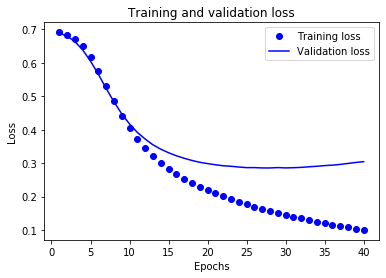

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

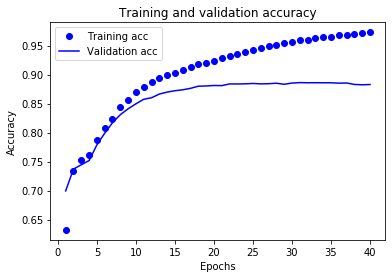

In [26]:
plt.clf()   # 図のクリア

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

上記のグラフでは、点が訓練時の損失と正解率を、実線が検証時の損失と正解率を表しています。

訓練時の損失がエポックごとに減少し、訓練時の正解率がエポックごとに上昇していることに気がつくはずです。

繰り返すごとに指定された数値指標を最小化する勾配降下法を最適化に使用している場合に期待される動きです。

これは、検証時の損失と正解率には当てはまりません。20エポックを過ぎたあたりから、横ばいになっているようです。

これが、過学習の一例です。モデルの性能が、訓練用データでは高い一方で、見たことの無いデータではそれほど高くないというものです。

このポイントをすぎると、モデルが最適化しすぎて、訓練用データでは特徴的であるが、テスト用データには一般化できない内部表現を学習しています。

このケースの場合、20エポックを過ぎたあたりで訓練をやめることで、過学習を防止することが出来ます。後ほど、コールバックを使って、これを自動化する方法を紹介します。

# 3.異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。


* Iris（Iris-versicolorとIris-virginicaのみの2値分類）
* Iris（3種類全ての目的変数を使用して多値分類）
* House Prices
* MNIST

Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。


KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

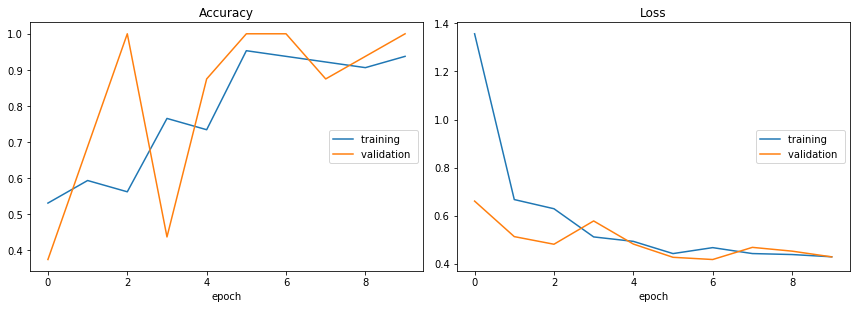

Accuracy
	training         	 (min:    0.531, max:    0.953, cur:    0.938)
	validation       	 (min:    0.375, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.428, max:    1.357, cur:    0.428)
	validation       	 (min:    0.417, max:    0.660, cur:    0.428)
64/64 [==============================] - 0s 5ms/sample - loss: 0.4283 - acc: 0.9375 - val_loss: 0.4278 - val_acc: 1.0000
Test loss: 0.4384687840938568
Test acc: 0.9


In [2]:
# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

df = df[df["Species"].isin(["Iris-versicolor","Iris-virginica"])]

#特徴量を抽出
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)

# ラベルをonehot化
y = np.array(pd.get_dummies(df["Species"]))
#データ型を変換
y = y.astype(np.int)


# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)



#kerasで4層のモデル作成
tf.reset_default_graph()#データグラフをリセット

input_data = tf.keras.layers.Input(shape=(4,))#入力層（特徴量が4種類）

layer_1 = tf.keras.layers.Dense(40,activation=tf.nn.relu,kernel_initializer='he_normal')(input_data)#ノード数が40、活性化関数がReLU、初期化手法がhe_normal、入力層からの入力を入力
layer_2 = tf.keras.layers.Dense(20,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_1)#ノード数が20、活性化関数がReLU、初期化手法がhe_normal、layer_1からの入力を入力
layer_3 = tf.keras.layers.Dense(10,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_2)#ノード数が１0、活性化関数がReLU、初期化手法がhe_normal、layer_2からの入力を入力

output = tf.keras.layers.Dense(2,activation=tf.nn.softmax)(layer_3)#２値分類なので出力は2、分類問題の出力なので活性化関数はsoftmax

model = tf.keras.Model(inputs=input_data,outputs=output)#入力層と出力層を入れてmodelを作成

model.summary()#モデル構造の可視化

model.compile(#いろいろ設定してモデルをコンパイルする
    loss='binary_crossentropy',#損失関数
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001),#最適化手法
    metrics=['accuracy']#評価指標を設定
)

#callbacks
cb_Plot = PlotLossesKeras()
cb_MC = ModelCheckpoint(filepath="/Users/nobu/diveintocode-ml/term-3/tweet_weight", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(#学習させる
    X_train,#訓練データ
    y_train,
    batch_size=10,#バッチサイズ
    epochs=100,#エポック数
    validation_data=(X_val, y_val),
    callbacks=[cb_AE,cb_Plot],
    verbose=1
    )
#vervose=0の時は学習経過表示しない、１の時はバッチごと、2の時はエポックごとに表示


#推定
y_pred = model.predict(X_train)
#print('y_pred:', y_pred[:10])

#testデータのスコアと損失を算出
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test acc:', score[1])


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

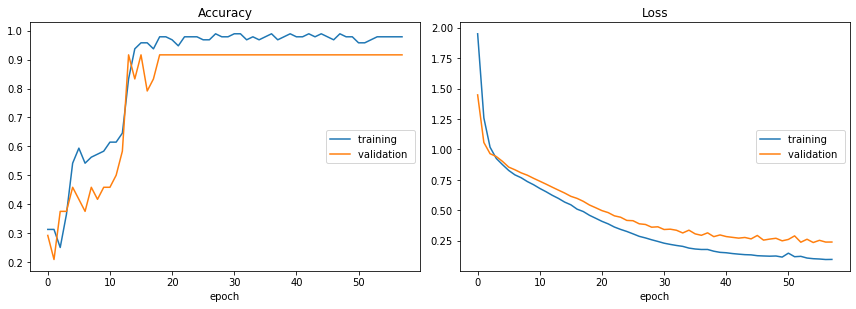

Accuracy
	training         	 (min:    0.250, max:    0.990, cur:    0.979)
	validation       	 (min:    0.208, max:    0.917, cur:    0.917)
Loss
	training         	 (min:    0.096, max:    1.950, cur:    0.097)
	validation       	 (min:    0.235, max:    1.448, cur:    0.239)
96/96 [==============================] - 0s 4ms/sample - loss: 0.0967 - acc: 0.9792 - val_loss: 0.2395 - val_acc: 0.9167
==========test============
Test loss: 0.10481183975934982
Test acc: 1.0


In [3]:
# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

#特徴量を抽出
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)

# ラベルをonehot化
y = np.array(pd.get_dummies(df["Species"]))
#データ型を変換
y = y.astype(np.int)


# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)



#kerasで4層のモデル作成
tf.reset_default_graph()#データグラフをリセット

input_data = tf.keras.layers.Input(shape=(4,))#入力層（特徴量が4種類）

layer_1 = tf.keras.layers.Dense(40,activation=tf.nn.relu,kernel_initializer='he_normal')(input_data)#ノード数が40、活性化関数がReLU、初期化手法がhe_normal、入力層からの入力を入力
layer_2 = tf.keras.layers.Dense(20,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_1)#ノード数が20、活性化関数がReLU、初期化手法がhe_normal、layer_1からの入力を入力
layer_3 = tf.keras.layers.Dense(10,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_2)#ノード数が１0、活性化関数がReLU、初期化手法がhe_normal、layer_2からの入力を入力

output = tf.keras.layers.Dense(3,activation=tf.nn.softmax)(layer_3)#２値分類なので出力は1、分類問題の出力なので活性化関数はsoftmax

model = tf.keras.Model(inputs=input_data,outputs=output)#入力層と出力層を入れてmodelを作成

model.summary()#モデル構造の可視化

model.compile(#いろいろ設定してモデルをコンパイルする
    loss='categorical_crossentropy',#損失関数
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001),#最適化手法
    metrics=['accuracy']#評価指標を設定
)

#callbacks
cb_AE = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cb_Plot = PlotLossesKeras()


history = model.fit(#学習させる
    X_train,#訓練データ
    y_train,
    batch_size=10,#バッチサイズ
    epochs=100,#エポック数
    validation_data=(X_val, y_val),#検証用データ
    callbacks=[cb_AE,cb_Plot],
    verbose=1
    )
#vervose=0の時は学習経過表示しない、１の時はバッチごと、2の時はエポックごとに表示

#推定
y_pred = model.predict(X_train)
#print('y_pred:', y_pred[:10])

#testデータのスコアと損失を算出
score = model.evaluate(X_test, y_test, verbose=0)
print("==========test============")
print('Test loss:', score[0])
print('Test acc:', score[1])


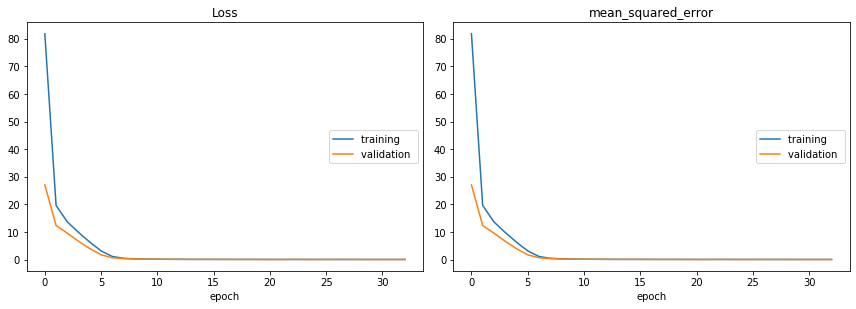

Loss
	training         	 (min:    0.060, max:   81.763, cur:    0.061)
	validation       	 (min:    0.052, max:   27.057, cur:    0.073)
mean_squared_error
	training         	 (min:    0.060, max:   81.763, cur:    0.061)
	validation       	 (min:    0.052, max:   27.057, cur:    0.073)
934/934 [==============================] - 1s 600us/sample - loss: 0.0611 - mean_squared_error: 0.0611 - val_loss: 0.0735 - val_mean_squared_error: 0.0735
Test loss: 0.07302681611825342
Test mse: 0.07302681


In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# データセットの読み込み
df = pd.read_csv("/Users/nobu/Documents/データセット/house-prices-advanced-regression-techniques/train.csv")

#データセット
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea","YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

#対数変換
y = np.log(y)
X = np.log(X)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#特徴量を標準化
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
X_val = std.transform(X_val)


#kerasで4層のモデル作成
tf.reset_default_graph()#データグラフをリセット

input_data = tf.keras.layers.Input(shape=(2,))#入力層（特徴量が4種類）

layer_1 = tf.keras.layers.Dense(40,activation=tf.nn.relu,kernel_initializer='he_normal')(input_data)#ノード数が40、活性化関数がReLU、初期化手法がhe_normal、入力層からの入力を入力
layer_2 = tf.keras.layers.Dense(20,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_1)#ノード数が20、活性化関数がReLU、初期化手法がhe_normal、layer_1からの入力を入力
layer_3 = tf.keras.layers.Dense(10,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_2)#ノード数が１0、活性化関数がReLU、初期化手法がhe_normal、layer_2からの入力を入力

output = tf.keras.layers.Dense(1,activation="linear")(layer_3)#２値分類なので出力は1、回帰問題の出力なので活性化関数はlinear
 
model = tf.keras.Model(inputs=input_data,outputs=output)#入力層と出力層を入れてmodelを作成

print(model.summary())#モデル構造の可視化

model.compile(#いろいろ設定してモデルをコンパイルする
    loss='mse',#損失関数
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001),#最適化手法
    metrics=['mse']#評価指標を設定
)

#callbacks
cb_AE = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
cb_Plot = PlotLossesKeras()



history = model.fit(#学習させる
    X_train,#訓練データ
    y_train,
    batch_size=10,#バッチサイズ
    epochs=100,#エポック数
    validation_data=(X_val, y_val),#検証用データ
    callbacks=[cb_AE,cb_Plot],
    verbose=1
    )
#vervose=0の時は学習経過表示しない、１の時はバッチごと、2の時はエポックごとに表示

#推定
y_pred = model.predict(X_train)
#print('y_pred:', y_pred[:10])

#testデータのスコアと損失を算出
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mse:', score[1])


# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [75]:
# データセットの読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#特徴量の前処理
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#目的変数の前処理（ワンホット化）
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


#kerasで4層のモデル作成
tf.reset_default_graph()#データグラフをリセット

input_data = tf.keras.layers.Input(shape=(784,))#入力層（特徴量が784種類）

layer_1 = tf.keras.layers.Dense(100,activation=tf.nn.relu,kernel_initializer='he_normal')(input_data)#ノード数が400、活性化関数がReLU、初期化手法がhe_normal、入力層からの入力を入力
layer_2 = tf.keras.layers.Dense(50,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_1)#ノード数が200、活性化関数がReLU、初期化手法がhe_normal、layer_1からの入力を入力
layer_3 = tf.keras.layers.Dense(50,activation=tf.nn.relu,kernel_initializer='he_normal')(layer_2)#ノード数が１00、活性化関数がReLU、初期化手法がhe_normal、layer_2からの入力を入力

output = tf.keras.layers.Dense(10,activation=tf.nn.softmax)(layer_3)#10値分類なので出力は10、分類問題の出力なので活性化関数はsoftmax

model = tf.keras.Model(inputs=input_data,outputs=output)#入力層と出力層を入れてmodelを作成

model.summary()#モデル構造の可視化

model.compile(#いろいろ設定してモデルをコンパイルする
    loss='categorical_crossentropy',#損失関数
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),#最適化手法
    metrics=['accuracy']#評価指標を設定
)


#callbacks
cb_AE = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cb_Plot = PlotLossesKeras()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 86,610
Trainable params: 86,610
Non-trainable params: 0
_________________________________________________________________


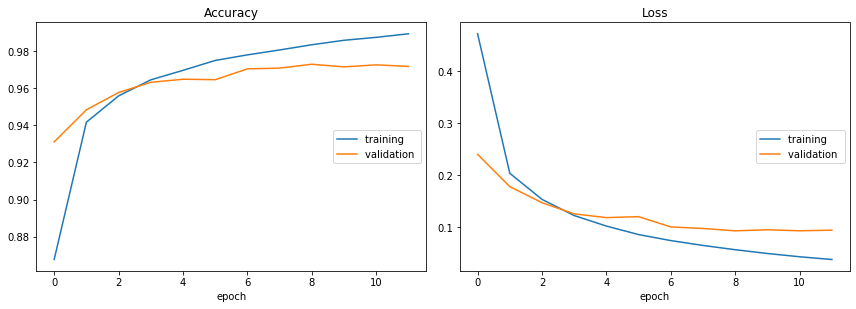

Accuracy
	training         	 (min:    0.868, max:    0.989, cur:    0.989)
	validation       	 (min:    0.931, max:    0.973, cur:    0.972)
Loss
	training         	 (min:    0.038, max:    0.472, cur:    0.038)
	validation       	 (min:    0.093, max:    0.240, cur:    0.094)
48000/48000 [==============================] - 8s 169us/sample - loss: 0.0377 - acc: 0.9894 - val_loss: 0.0941 - val_acc: 0.9718
Test loss: 0.09627929686522112
Test acc: 0.9727
CPU times: user 2min 16s, sys: 27.7 s, total: 2min 44s
Wall time: 1min 35s


In [76]:
%%time
history = model.fit(#学習させる
    X_train,#訓練データ
    y_train,
    batch_size=10,#バッチサイズ
    epochs=100,#エポック数
    validation_data=(X_val, y_val),#検証用データ
    callbacks=[cb_AE,cb_Plot],
    verbose=1
    )
#vervose=0の時は学習経過表示しない、１の時はバッチごと、2の時はエポックごとに表示

#推定
y_pred = model.predict(X_train)
#print('y_pred:', y_pred[:10])
#testデータのスコアと損失を算出
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test acc:', score[1])


# 【問題7】（アドバンス課題）PyTorchへの書き換え

4種類の問題をPyTorchに書き換えてください。

https://rf00.hatenablog.com/entry/2018/05/13/180739

https://www.pytry3g.com/entry/2018/04/27/225711

https://qiita.com/sudominoru/items/544aec4dc867187a93fa

## Iris（2値分類）

In [6]:
#データ準備

# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[df["Species"].isin(["Iris-versicolor","Iris-virginica"])]

#特徴量抽出、変換
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)

#目的変数抽出、変換
y = df["Species"]
y = np.array(y)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


# 分割したものをpytorchで扱えるtensor型に変換
import torch

train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.LongTensor(y_train)#整数を扱う場合はlong型を使う（intじゃラベルとして扱うことがで機内）
val_y = torch.LongTensor(y_val)

In [7]:
#ネットワーク構築

import torch.nn as nn#ニューラルネットワークモジュールの基本クラス
import torch.nn.functional as F#pytorchのNN構成に使うメソッドを呼び出す
from torch.autograd import Variable#自動微分パッケージ

torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう

class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        #層を定義
        self.fc1 = nn.Linear(4, 100)#(入力、出力)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)#2値分類なので２
    
    #順伝播
    def forward(self, x):
        x = F.relu(self.fc1(x))#F(nn.function)から活性化関数を呼び出し、各層に適応
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out_x = F.log_softmax(x, dim=1)#順伝播で流れてきた最終層にソフトマックスを通し対数をとる
        #dimはnumpyのaxisと一緒
        return out_x

#ネットワークのインスタンス作成
model = Net()

import torch.optim as optim#オプティマイザーを呼び出す
#作成したNNモデルにoptimizerを追加
optimizer = optim.SGD(model.parameters(), lr=0.02)

#ネットワークがどんな層で構成されているか確認
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


Epoch: 1.0	Loss: 0.660	Accuracy: 0.531
Epoch: 2.0	Loss: 0.645	Accuracy: 0.531
Epoch: 3.0	Loss: 0.629	Accuracy: 0.562
Epoch: 4.0	Loss: 0.611	Accuracy: 0.656
Epoch: 5.0	Loss: 0.591	Accuracy: 0.734
Epoch: 6.0	Loss: 0.569	Accuracy: 0.766
Epoch: 7.0	Loss: 0.544	Accuracy: 0.828
Epoch: 8.0	Loss: 0.515	Accuracy: 0.859
Epoch: 9.0	Loss: 0.487	Accuracy: 0.938
Epoch: 10.0	Loss: 0.457	Accuracy: 0.938


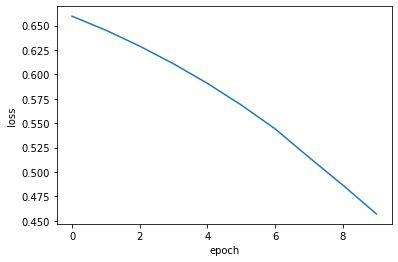

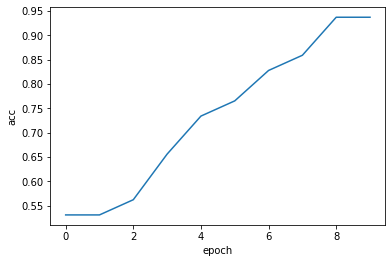

val_Accuracy: 0.938


In [8]:
#学習

#損失,acc記録用
train_loss = []
train_accu = []

#イテレーション数を初期化
i = 0

#学習モード
model.train() 
for epoch in range(100):
    #微分可能な型に変換
    data, target = Variable(train_X), Variable(train_y)
    #勾配初期化
    optimizer.zero_grad() 
    #データを流す
    output = model(data) 
    #loss計算
    loss = F.nll_loss(output, target) 
    #バックプロパゲーション
    loss.backward() 
    #予測結果
    prediction = output.data.max(1)[1] 
    #正解率
    accuracy = prediction.eq(target.data).sum().numpy() / len(train_X) 
    
    # パラメータ更新
    optimizer.step()   
    
    #10イテレーション＝１エポックとして1エポックごとにlossとaccを出力
    i += 1
    if i % 10 == 0:
        print('Epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i/10, loss, accuracy))
        #エポックごとにlossとaccを格納
        train_loss.append(loss)
        train_accu.append(accuracy)


#lossの推移を描画
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss)
plt.show()

#laccの推移を描画
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(train_accu)
plt.show()


#学習したモデルを用いてvalデータに対して検証

#推論モード
model.eval() 
#valデータを微分可能な型に変換
val_output = model(Variable(val_X))

#予測結果
_, predicted = torch.max(val_output.data, 1)

#acc出力
print('val_Accuracy: {:.3f}'.format(predicted.eq(val_y).sum().numpy() / len(predicted)))


## Iris（多値分類）

In [9]:
#データ準備

# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

#特徴量抽出、変換
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)

#目的変数抽出、変換
y = df["Species"]
y = np.array(y)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

y = y.astype(np.int)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


# 分割したものをpytorchで扱えるtensor型に変換
import torch

train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.LongTensor(y_train)#整数を扱う場合はlong型を使う（intじゃラベルとして扱うことがで機内）
val_y = torch.LongTensor(y_val)

In [10]:
#ネットワーク構築

import torch.nn as nn#ニューラルネットワークモジュールの基本クラス
import torch.nn.functional as F#pytorchのNN構成に使うメソッドを呼び出す
from torch.autograd import Variable#自動微分パッケージ

torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう

class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        #層を定義
        self.fc1 = nn.Linear(4, 100)#(入力、出力)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)#3値分類なので3
    
    #順伝播
    def forward(self, x):
        x = F.relu(self.fc1(x))#F(nn.function)から活性化関数を呼び出し、各層に適応
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out_x = F.log_softmax(x, dim=1)#順伝播で流れてきた最終層にソフトマックスを通し対数をとる
        #dimはnumpyのaxisと一緒
        return out_x

#ネットワークのインスタンス作成
model = Net()

import torch.optim as optim#オプティマイザーを呼び出す
#作成したNNモデルにoptimizerを追加
optimizer = optim.SGD(model.parameters(), lr=0.02)

#ネットワークがどんな層で構成されているか確認
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


Epoch: 1.0	Loss: 0.962	Accuracy: 0.406
Epoch: 2.0	Loss: 0.853	Accuracy: 0.688
Epoch: 3.0	Loss: 0.746	Accuracy: 0.688
Epoch: 4.0	Loss: 0.652	Accuracy: 0.688
Epoch: 5.0	Loss: 0.578	Accuracy: 0.698
Epoch: 6.0	Loss: 0.521	Accuracy: 0.719
Epoch: 7.0	Loss: 0.478	Accuracy: 0.771
Epoch: 8.0	Loss: 0.443	Accuracy: 0.833
Epoch: 9.0	Loss: 0.413	Accuracy: 0.875
Epoch: 10.0	Loss: 0.386	Accuracy: 0.917


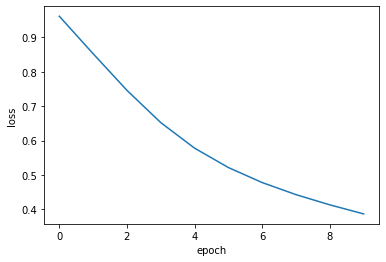

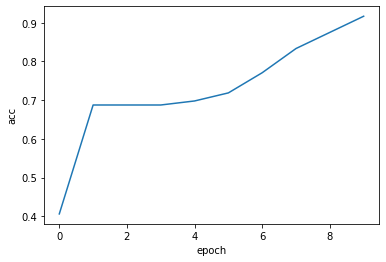

val_Accuracy: 0.833


In [11]:
#学習

#損失,acc記録用
train_loss = []
train_accu = []

#イテレーション数を初期化
i = 0

#学習モード
model.train() 
for epoch in range(100):
    #微分可能な型に変換
    data, target = Variable(train_X), Variable(train_y)
    #勾配初期化
    optimizer.zero_grad() 
    #データを流す
    output = model(data) 
    #loss計算
    loss = F.nll_loss(output, target) 
    #バックプロパゲーション
    loss.backward() 
    #予測結果
    prediction = output.data.max(1)[1] 
    #正解率
    accuracy = prediction.eq(target.data).sum().numpy() / len(train_X) 
    
    # パラメータ更新
    optimizer.step()   
    
    #10イテレーション＝１エポックとして1エポックごとにlossとaccを出力
    i += 1
    if i % 10 == 0:
        print('Epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i/10, loss, accuracy))
        #エポックごとにlossとaccを格納
        train_loss.append(loss)
        train_accu.append(accuracy)


#lossの推移を描画
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss)
plt.show()

#laccの推移を描画
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(train_accu)
plt.show()


#学習したモデルを用いてvalデータに対して検証

#推論モード
model.eval() 
#valデータを微分可能な型に変換
val_output = model(Variable(val_X))

#予測結果
_, predicted = torch.max(val_output.data, 1)

#acc出力
print('val_Accuracy: {:.3f}'.format(predicted.eq(val_y).sum().numpy() / len(predicted)))


## House Prices

In [44]:
# データセットの読み込み
df = pd.read_csv("/Users/nobu/Documents/データセット/house-prices-advanced-regression-techniques/train.csv")

#データセット
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea","YearBuilt"]]

y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

#対数変換
y = np.log(y)
X = np.log(X)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#特徴量を標準化
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
X_val = std.transform(X_val)



# 分割したものをpytorchで扱えるtensor型に変換
import torch

train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.Tensor(y_train)
val_y = torch.Tensor(y_val)

In [54]:
#ネットワーク構築

import torch.nn as nn#ニューラルネットワークモジュールの基本クラス
import torch.nn.functional as F#pytorchのNN構成に使うメソッドを呼び出す
from torch.autograd import Variable#自動微分パッケージ

torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう

class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        #層を定義
        self.fc1 = nn.Linear(2, 100)#(入力、出力)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)#回帰なので１
    
    #順伝播
    def forward(self, x):
        x = F.relu(self.fc1(x))#F(nn.function)から活性化関数を呼び出し、各層に適応
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
       
        return x

#ネットワークのインスタンス作成
model = Net()

import torch.optim as optim#オプティマイザーを呼び出す
#作成したNNモデルにoptimizerを追加
optimizer = optim.SGD(model.parameters(), lr=0.1)

#ネットワークがどんな層で構成されているか確認
print(model)

Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


Epoch: 1.0	MSE: 17.570
Epoch: 2.0	MSE: 0.220
Epoch: 3.0	MSE: 0.057
Epoch: 4.0	MSE: 0.051
Epoch: 5.0	MSE: 0.049
Epoch: 6.0	MSE: 0.047
Epoch: 7.0	MSE: 0.047
Epoch: 8.0	MSE: 0.046
Epoch: 9.0	MSE: 0.046
Epoch: 10.0	MSE: 0.046


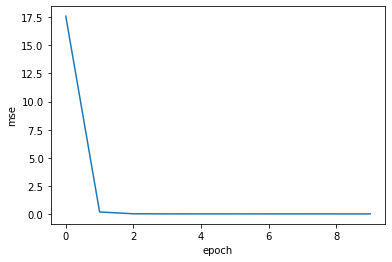

In [55]:
#学習

#mse記録用
train_mse = []

#イテレーション数を初期化
i = 0

#学習モード
model.train() 
for epoch in range(100):
    #微分可能な型に変換
    data, target = Variable(train_X), Variable(train_y)
    #勾配初期化
    optimizer.zero_grad() 
    #データを流す
    output = model(data) 
    #mse計算
    mse = F.mse_loss(output, target) 
    #バックプロパゲーション
    mse.backward() 
    #予測結果
    prediction = output
    
    # パラメータ更新
    optimizer.step()   
    
    #10イテレーション＝１エポックとして1エポックごとにlossとaccを出力
    i += 1
    if i % 10 == 0:
        print('Epoch: {}\tMSE: {:.3f}'.format(i/10, mse))
        #エポックごとにlossとaccを格納
        train_mse.append(mse)


#laccの推移を描画
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(train_mse)
plt.show()

## MNIST

In [72]:
# データセットの読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#特徴量の前処理
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# 分割したものをpytorchで扱えるtensor型に変換
import torch

train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.LongTensor(y_train)#整数を扱う場合はlong型を使う（intじゃラベルとして扱うことがで機内）
val_y = torch.LongTensor(y_val)

In [73]:
#ネットワーク構築

import torch.nn as nn#ニューラルネットワークモジュールの基本クラス
import torch.nn.functional as F#pytorchのNN構成に使うメソッドを呼び出す
from torch.autograd import Variable#自動微分パッケージ

torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう

class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        #層を定義
        self.fc1 = nn.Linear(784, 100)#(入力、出力)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)#10値分類なので10
    
    #順伝播
    def forward(self, x):
        x = F.relu(self.fc1(x))#F(nn.function)から活性化関数を呼び出し、各層に適応
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out_x = F.log_softmax(x, dim=1)#順伝播で流れてきた最終層にソフトマックスを通し対数をとる
        #dimはnumpyのaxisと一緒
        return out_x

#ネットワークのインスタンス作成
model = Net()

import torch.optim as optim#オプティマイザーを呼び出す
#作成したNNモデルにoptimizerを追加
optimizer = optim.SGD(model.parameters(), lr=0.9)

#ネットワークがどんな層で構成されているか確認
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


Epoch: 1.0	Loss: 2.618	Accuracy: 0.267
Epoch: 2.0	Loss: 1.735	Accuracy: 0.425
Epoch: 3.0	Loss: 4.007	Accuracy: 0.306
Epoch: 4.0	Loss: 1.644	Accuracy: 0.477
Epoch: 5.0	Loss: 0.851	Accuracy: 0.723
Epoch: 6.0	Loss: 0.673	Accuracy: 0.784
Epoch: 7.0	Loss: 0.592	Accuracy: 0.800
Epoch: 8.0	Loss: 0.495	Accuracy: 0.836
Epoch: 9.0	Loss: 0.399	Accuracy: 0.874
Epoch: 10.0	Loss: 0.321	Accuracy: 0.901
Epoch: 11.0	Loss: 0.292	Accuracy: 0.912
Epoch: 12.0	Loss: 0.335	Accuracy: 0.900
Epoch: 13.0	Loss: 0.249	Accuracy: 0.925
Epoch: 14.0	Loss: 0.259	Accuracy: 0.921
Epoch: 15.0	Loss: 0.219	Accuracy: 0.934
Epoch: 16.0	Loss: 0.585	Accuracy: 0.800
Epoch: 17.0	Loss: 0.360	Accuracy: 0.901
Epoch: 18.0	Loss: 0.611	Accuracy: 0.773
Epoch: 19.0	Loss: 0.238	Accuracy: 0.931
Epoch: 20.0	Loss: 0.216	Accuracy: 0.937
Epoch: 21.0	Loss: 0.207	Accuracy: 0.939
Epoch: 22.0	Loss: 0.409	Accuracy: 0.872
Epoch: 23.0	Loss: 0.194	Accuracy: 0.943
Epoch: 24.0	Loss: 0.183	Accuracy: 0.946
Epoch: 25.0	Loss: 0.401	Accuracy: 0.867
Epoch: 26

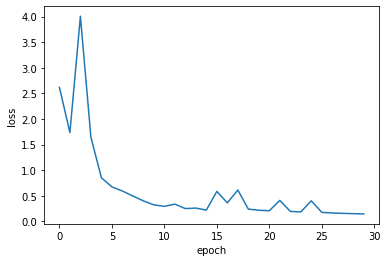

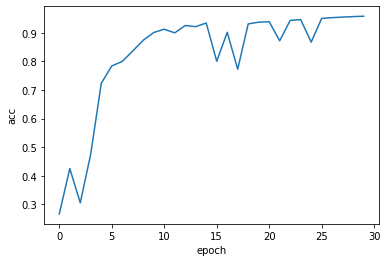

val_Accuracy: 0.952
CPU times: user 4min 24s, sys: 8.93 s, total: 4min 33s
Wall time: 46.3 s


In [74]:
%%time
#学習

#損失,acc記録用
train_loss = []
train_accu = []

#イテレーション数を初期化
i = 0

#学習モード
model.train() 
for epoch in range(300):
    #微分可能な型に変換
    data, target = Variable(train_X), Variable(train_y)
    #勾配初期化
    optimizer.zero_grad() 
    #データを流す
    output = model(data) 
    #loss計算
    loss = F.nll_loss(output, target) 
    #バックプロパゲーション
    loss.backward() 
    #予測結果
    prediction = output.data.max(1)[1] 
    #正解率
    accuracy = prediction.eq(target.data).sum().numpy() / len(train_X) 
    
    # パラメータ更新
    optimizer.step()   
    
    #10イテレーション＝１エポックとして1エポックごとにlossとaccを出力
    i += 1
    if i % 10 == 0:
        print('Epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i/10, loss, accuracy))
        #エポックごとにlossとaccを格納
        train_loss.append(loss)
        train_accu.append(accuracy)


#lossの推移を描画
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss)
plt.show()

#laccの推移を描画
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(train_accu)
plt.show()


#学習したモデルを用いてvalデータに対して検証

#推論モード
model.eval() 
#valデータを微分可能な型に変換
val_output = model(Variable(val_X))

#予測結果
_, predicted = torch.max(val_output.data, 1)

#acc出力
print('val_Accuracy: {:.3f}'.format(predicted.eq(val_y).sum().numpy() / len(predicted)))


# 【問題8】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。


《視点例》


計算速度
コードの行数・可読性
用意されている機能

### Tensorflow・Keras・Pytorchの三つを各項目ごとに比較する

優れている＞劣っている

* 計算速度（MNISTを例に）

Keras(2min 44s) > (TensorFlow(3min 27s) > Pytorch(4min 33s))

精度が変わってしまい、学習率等を全て同じ条件で比較することができなかったためなんとも言えないが、
上記の時間でそれぞれACC=0.96くらいまで到達した。

* コードの行数

Keras > Pytorch ≒ Tensorflow

Kerasが最も短い、他の二つは同じくらいだと感じる（主観）

* 可読性

keras > Pytorch > Tensorflow

Tensrflowが一番わかりにくかった（主観）

* 用意されている機能

不明

まだどれも機能を使いこなせていない。しかし調べる限り、Pytorchは研究向けで応用が効くとこと。